In [1]:
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

import pymysql
pymysql.install_as_MySQLdb()

import datetime as dt
import pandas as pd
import seaborn as sns
#from sqlalchemy import desc

*start and end dates were removed into Temperature Analysis paragraph*

**Create engine**

In [3]:
engine = create_engine('sqlite:///../Base/hawaii.sqlite')

In [4]:
#check if everything works
engine.execute('select * from station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999995, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

**Check tables and column names**

In [5]:
inspector = inspect(engine)

In [6]:
tables = {} # keep all tables and columns. maybe useless
for table in inspector.get_table_names():
    print(f'Table name is "{table}", it contains columns: ')
    columns = inspector.get_columns(table)
    names = []
    for c in columns:
        names.append(c['name'])
        print(c['name'], c['type'])
    print()
    tables[table] = names

Table name is "measurement", it contains columns: 
id INTEGER
station VARCHAR
date VARCHAR
prcp FLOAT
tobs INTEGER

Table name is "station", it contains columns: 
id INTEGER
station VARCHAR
name VARCHAR
latitude FLOAT
longitude FLOAT
elevation FLOAT



**Declare a Base using automap and reflect database**

In [7]:
Base = automap_base()
Base.prepare(engine, reflect=True)

**Assign classes to variable**

In [8]:
Measurement = Base.classes.measurement
Station = Base.classes.station

## Precipitation Analysis

**Start a session to make queries**

In [9]:
session = Session(engine)

**Get information for the last year**

In [58]:
#find the last date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#convert string to df format
date = dt.datetime.strptime(last_date[0], "%Y-%m-%d")
#subtract 365 days
year_ago = date - dt.timedelta(days=365)

In [59]:
last_year_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_ago).all()

**Create DF and plot it**

In [60]:
df = pd.DataFrame(last_year_prcp, columns=['date', 'precipitation'])
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


Text(0,0.5,'Precipitation')

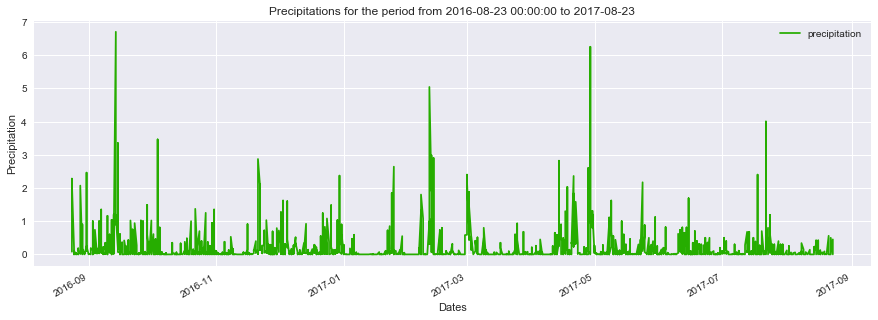

In [61]:
sns.set()
ax = df.plot(title=f'Precipitations for the period from {year_ago} to {last_date[0][0:10]}', color='#26ad00',\
             grid=True, figsize=(15,5))
ax.set_xlabel('Dates')
ax.set_ylabel('Precipitation')

**Get percipitation statistics**

In [62]:
df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [17]:
# Total # of stations
session.query(Measurement.station).distinct().count()

9

In [18]:
# List of stations activity
session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).\
order_by(func.count(Measurement.id).desc()).all()

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [19]:
# Most active station
most_active = session.query(Measurement.station).group_by(Measurement.station).\
order_by(func.count(Measurement.id).desc()).first()
most_active

('USC00519281')

In [20]:
last_year_temp = session.query(Measurement.tobs).filter(Measurement.date > year_ago).\
                    filter(Measurement.station == most_active[0]).all()

In [21]:
df = pd.DataFrame(last_year_temp, columns=['Temperature'])

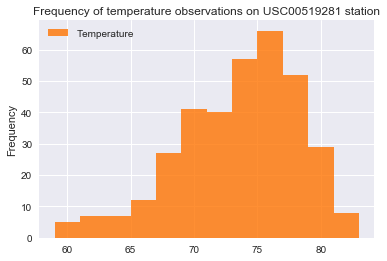

In [30]:
df.plot.hist(by='Temperature', bins=12, color='#ff7300',\
             title=f'Frequency of temperature observations on {most_active[0]} station', alpha=0.8)

## Temperature Analysis

**Create a function**

In [98]:
start_date = dt.datetime.strptime(input('Enter start date in format %Y-%m-%d'), "%Y-%m-%d")
end_date = dt.datetime.strptime(input('Enter end date in format %Y-%m-%d'), "%Y-%m-%d")

Enter start date in format %Y-%m-%d2016-02-10
Enter end date in format %Y-%m-%d2016-02-20


In [99]:
def calc_temps(start, end):
    '''Calculates minimun, average and maximum temperature for a period of dates
    start and end dates should be in a datetime format'''
    query = session.query((func.min(Measurement.tobs)), (func.avg(Measurement.tobs)), (func.max(Measurement.tobs))).\
    filter(Measurement.date > start).filter(Measurement.date < end).all()
    tempts = [x for x in query[0]]
    return tempts

**Find 'a year ago' temperatures**

In [100]:
a_year_ago_temps = calc_temps(start_date - dt.timedelta(days=365), end_date - dt.timedelta(days=365))

**Plot it**

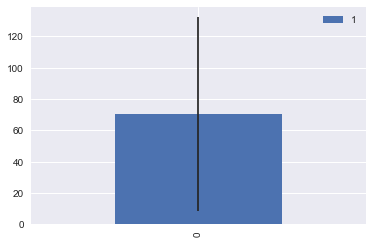

In [74]:
err = pd.DataFrame(a_year_ago_temps)
pd.DataFrame(a_year_ago_temps).transpose().plot.bar(y=1, yerr=err[0])

,0
0,62.000000
1,73.012346
2,79.000000


**Plot in a 1 step way**

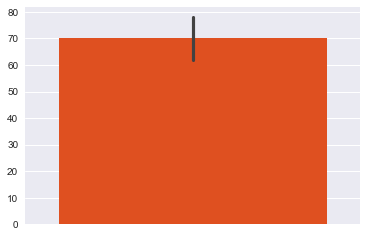

In [75]:
sns.barplot(y=a_year_ago_temps, color='#ff4000')

## Optional Recommended Analysis

In [46]:
#rainfall per weather station
session.query(Measurement.station, func.sum(Measurement.prcp)).filter((Measurement.date > year_ago)).\
group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00516128', 147.11000000000004),
 ('USC00519281', 68.24000000000002),
 ('USC00513117', 48.36000000000003),
 ('USC00519523', 37.99),
 ('USC00514830', 33.19),
 ('USC00519397', 16.089999999999986),
 ('USC00517948', 4.59)]

**Define a function**

In [185]:
def daily_normals(day):
    '''Calculates minimun, average and maximum temperature for a particular day taking into account all years.
    day - a string in format '%m-%d' '''
    day_dt = dt.datetime.strptime(day, '%m-%d')
    tempts = session.query((func.min(Measurement.tobs)), (func.avg(Measurement.tobs)), (func.max(Measurement.tobs))).\
    filter(func.strftime('%m', Measurement.date) == day_dt.strftime('%m')).\
    filter(func.strftime('%d', Measurement.date) == day_dt.strftime('%d')).\
    all()
    return tempts[0]

**Create a list of vacation days**

In [186]:
vacation_days = []
for d in [dt.datetime.strptime(d[0], '%Y-%m-%d') for d in session.query(Measurement.date).\
          filter(Measurement.date > start_date).filter(Measurement.date < end_date).group_by(Measurement.date).all()]:
    vacation_days.append(f'{d.month}-{d.day}')

In [187]:
vacation_days

['2-11',
 '2-12',
 '2-13',
 '2-14',
 '2-15',
 '2-16',
 '2-17',
 '2-18',
 '2-19',
 '2-20']

In [188]:
vacation_temps = {}
for day in vacation_days:
    vacation_temps[day] = daily_normals(day)

In [189]:
vacation_temps

{'2-11': (61, 69.23076923076923, 79),
 '2-12': (60, 69.23076923076923, 78),
 '2-13': (58, 70.32075471698113, 80),
 '2-14': (62, 70.76470588235294, 79),
 '2-15': (56, 70.05454545454545, 79),
 '2-16': (59, 70.43396226415095, 76),
 '2-17': (62, 70.34693877551021, 77),
 '2-18': (63, 70.61224489795919, 77),
 '2-19': (60, 69.45833333333333, 77),
 '2-20': (63, 70.125, 76)}